## Generating figures for the poster

pare down the figures by focusing on a couple narrower subset of LLM, phenotypes, and scenarios to focus separately on the comparison (a) across LLMs, (b) across prompts/features, and (c) across phenotypes. The most important comparison is the bottom-right panel – gpt-4o for aTRH Dx

In [2]:
import sys; sys.path.append('./notebooks/')
from _load_llm_results import *
import numpy as np
import warnings
import os
import sys; sys.path.append('../')
from evaluate_model import read_data
import json

warnings.filterwarnings("ignore")

%matplotlib inline

from tqdm import tqdm
from glob import glob


In [3]:
def load_results(constraints=dict(scale=[False])):
    count = 0
    for file in tqdm(glob(f"{results_path}/**/*.json", recursive=True)):
        # print(file)

        try:
            cp_df = pd.read_json(file, typ="series")
        except Exception as e:
            # print("Bad results in file", file)
            continue
        
        # unifying column name
        cp_df = cp_df.rename(index={"few_feature": "icd_only"})

        # stay = True
        # for kc, vc in constraints.items():
        #     if df[kc] not in vc:
        #         stay = False
        #         print("skipping", file)
        #         break
        # if not stay:
        #     print('continuing')
        #     continue

        indxs = cp_df.index
        # indxs = [indx for indx in indxs if indx not in ['pred', 'pred_proba']]

        results.append(cp_df[indxs])
        count += 1

    print('loaded',count,'files')
    results_df = pd.DataFrame(data=results, columns=indxs)

    # Beautifying it
    results_df["model"] = results_df["model"].apply(lambda m: nice_model_labels[m])
    results_df["target"] = results_df["target"].apply(lambda t: dnames_to_nice[t])

    results_df = results_df[results_df["model"].isin(order)]

    print(results_df["model"].unique())
    print(results_df["target"].unique())
    return results_df
    
boxplot_kwargs = {
    'sharey':True,
    'notch': False,
    'showcaps':True,
    'flierprops':{"marker": "x"},
    # 'boxprops':{"facecolor": 'white'},
    'medianprops':{"color": "k", "linewidth": 1, 'alpha':0.5}
}

palette = sns.color_palette("hls", 6) # ['#374aa3', '#cc6666', '#6688d0', '#ffcccc', '#336699', '#99ccff']

phenotypes_order =  ['HTN Heuristic', 'Htn-Hypokalemia Heuristic', 'Resistant HTN Heuristic',
                     'HTN Diagnosis', 'HTN-Hypokalemia Diagnosis', 'Resistant HTN Diagnosis']

settings_order = ['Simple prompt,\nfew features', 'Simple prompt,\nall features', 
                  'Rich prompt,\nfew features',   'Rich prompt,\nall features']

model_order = [
    'gpt-3.5-turbo',
    'gpt-3.5-turbo-iter',
    'gpt-4o-mini',
    'gpt-4o-mini-iter',
    'gpt-4o',
    'gpt-4o-iter',
    'gpt-4-turbo',
    'gpt-4-turbo-iter',
]

results_df = load_results()
# display(results_df)

# Making it the format seaborn likes
results_df_melted = pd.melt(
    results_df, 
    id_vars=['model', 'target', 'fold', 'RunID', 'random_state', 'prompt_richness', 'icd_only']
)

print(results_df.columns)
print(results_df.shape)

100%|██████████| 7200/7200 [01:23<00:00, 86.28it/s] 


loaded 7200 files
['gpt-3.5-turbo' 'gpt-3.5-turbo-iter' 'gpt-4o' 'gpt-4o-iter' 'gpt-4o-mini'
 'gpt-4o-mini-iter']
['HTN Heuristic' 'HTN Diagnosis' 'HTN-Hypokalemia Diagnosis'
 'Htn-Hypokalemia Heuristic' 'Resistant HTN Heuristic'
 'Resistant HTN Diagnosis']
Index(['accuracy_score_train', 'precision_score_train',
       'average_precision_score_train', 'roc_auc_score_train',
       'balanced_accuracy_score_train', 'accuracy_score_test',
       'precision_score_test', 'average_precision_score_test',
       'roc_auc_score_test', 'balanced_accuracy_score_test', 'messages',
       'model', 'target', 'fold', 'RunID', 'random_state', 'representation',
       'representation_fmt', 'size', 'complexity', 'scale', 'icd_only',
       'prompt_richness', 'time', 'pred', 'pred_proba'],
      dtype='object')
(7200, 26)


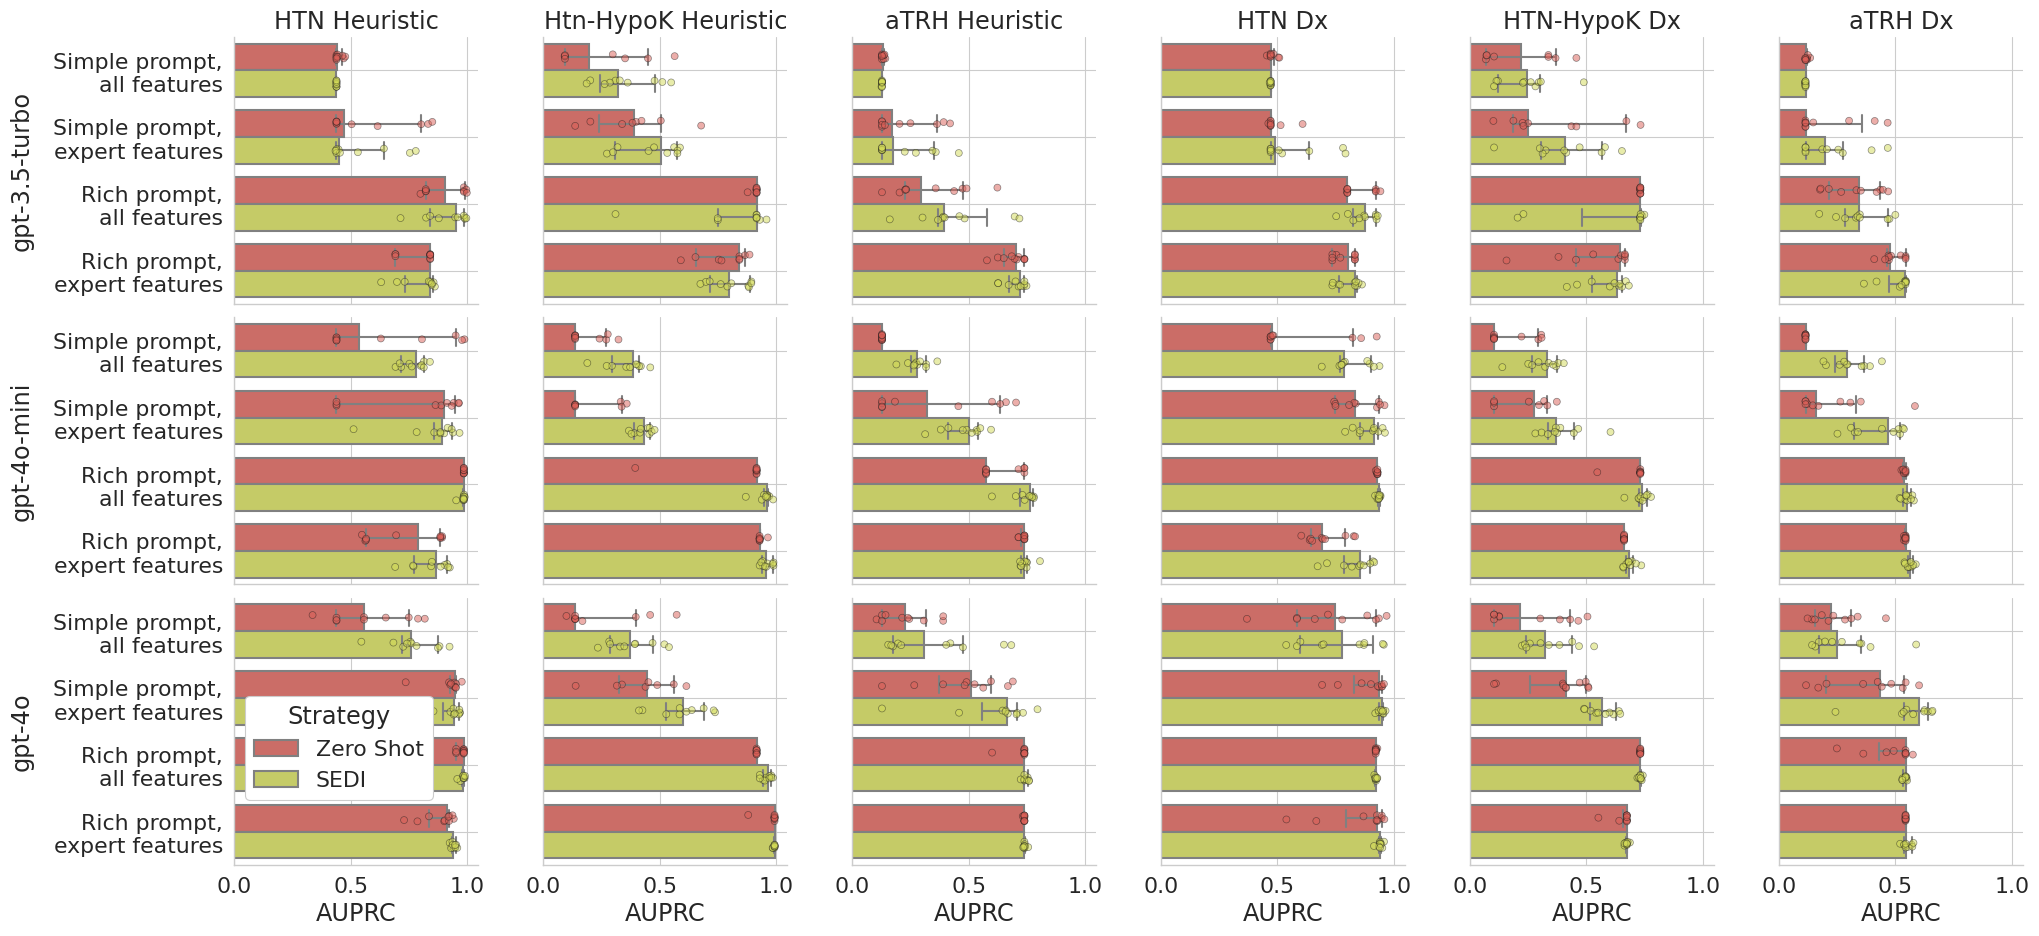

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.8
)

same_scale = True

def preprocess_data(results_df_melted, metric):
    """Prepares dataframe for plotting (grouping, renaming, derived columns)."""
    data = results_df_melted[results_df_melted['variable'] == metric].copy()
    data = data.groupby([c for c in data.columns if c not in ['fold', 'value']])['value'].mean().reset_index()

    data['Strategy'] = ['SEDI' if 'iter' in v else 'Zero Shot' for v in data['model'].values]
    
    metric_name = metric.replace('average_precision_score_test', 'AUPRC') # prettified version

    data = data.rename(columns={'value': metric_name})
    data['Model'] = data['model'].apply(lambda x: x.replace('-iter', ''))

    data['Setting'] = data[['icd_only', 'prompt_richness']].apply(
        lambda row: f"{'Rich prompt,\n' if row.prompt_richness else 'Simple prompt,\n'}"
                    f"{'expert features' if row.icd_only else 'all features'}",
        axis=1
    )
    data['Dx Description'] = data['prompt_richness'].apply(lambda x: 'Detailed' if x else 'Simple')
    data['Feature Set'] = data['icd_only'].apply(lambda x: 'Minimal' if x else 'Full')

    return data, metric_name

# sns.set_style('whitegrid')
# for target in results_df.target.unique():
for metric in [
    # 'accuracy_score_train',
    # 'accuracy_score_test',
    # 'average_precision_score_train',
    'average_precision_score_test',
    # 'roc_auc_score_train',
    # 'roc_auc_score_test',
    # 'size'
]: 
    data, metric_name = preprocess_data(results_df_melted, metric)
    
    hue_order=['Zero Shot','SEDI']

    plt_data_args = dict(
        # y='Model', 
        data=data,
        y='Setting',
        order = [
            'Simple prompt,\nall features',
            'Simple prompt,\nexpert features',
            'Rich prompt,\nall features',
            'Rich prompt,\nexpert features',
        ],
        x=metric_name, 
        # order=[m for m in model_order if m in data['Model'].unique()],
        hue='Strategy',
        hue_order=hue_order,
        palette = palette,
    )
    
    g = sns.catplot(
        row='Model',
        row_order=[m for m in model_order if m in data['Model'].unique()],
        col='target',
        col_order=phenotypes_order,
        aspect=1, 
        height=3,
        margin_titles=True,
        estimator=np.median,
        linewidth=1.5,
        kind='bar',
        dodge=True,
        capsize=.5,
        err_kws={"color": ".5", "linewidth": 2.5},
        edgecolor=".5",
        errorbar=('ci',95),
        errwidth=1.5,
        # facecolor='w',
        # errorbar=('pi',95),
        # kind="box", 
        # join=False,
        # dodge=True,
        sharex=(True if same_scale else 'col'),
        # **boxplot_kwargs,
        **plt_data_args
    )
    
    g.map_dataframe(sns.stripplot, dodge=True, **plt_data_args, alpha=.5, size=5,
        edgecolor="k", linewidth=0.5, jitter=True)
              
    g.set_titles(
        col_template="{col_name}",
        row_template='{row_name}')
    g.set_ylabels('')
    # g.set_xlabels(yaxis.replace(' test',''))

    g.set_xlabels(metric_name.replace('_', ' ').replace(' test',''))
    # g.set_xlabels(metric_name.replace('_', ' ').replace(' test','').title())

    plt.subplots_adjust(
        left=0.1,
        right=1,
        bottom=0,
        top=0.92,
        hspace = 0.05
    )
      
    for ax in g.axes.flat:
        ttl = ax.get_title()
        ax.set_title(
            ttl
            .replace('Diagnosis','Dx')
            .replace('Resistant HTN', 'aTRH')
            .replace('Hypokalemia','HypoK')
        )
        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        if 'roc' in metric:
            ax.set_xlim(left=0.4)
      
    sns.move_legend(
        g, 
        "upper left", 
        bbox_to_anchor=(0.1, .2),
        # ncols=2,
        frameon=True,
        framealpha=1
    )

    for margin_title in g._margin_titles_texts:
        # margin_title.set_color("red")
        margin_title.set_rotation(90)
        margin_title.set_position((
            (-7.25 if same_scale else -7.05), 
            margin_title.get_position()[1]
        ))

    plt.savefig(f"{poster_dir}/llm_comparison_{metric}_sharex={same_scale}.pdf",
               bbox_inches='tight')
    
    plt.savefig(f"{poster_dir}/llm_comparison_{metric}_sharex={same_scale}.jpeg",
               bbox_inches='tight')
    plt.show()

In [5]:
data, metric_name = preprocess_data(results_df_melted, "average_precision_score_test")

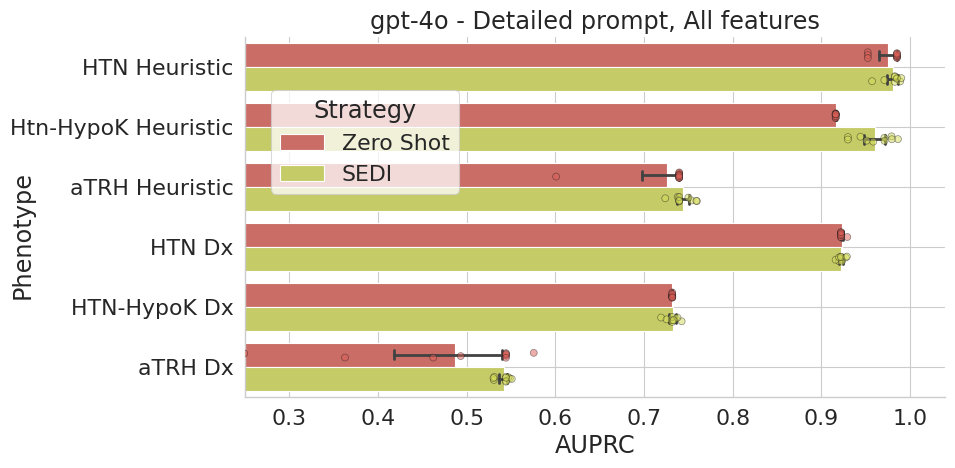

In [18]:
# Compare phenotypes for GPT‑4o, Rich+Full

order = [
    'HTN Heuristic',
    'Htn-Hypokalemia Heuristic',
    'Resistant HTN Heuristic',
    'HTN Diagnosis',
    'HTN-Hypokalemia Diagnosis',
    'Resistant HTN Diagnosis',
]

subset = data[(data['Model'] == "gpt-4o") &
                (data['Dx Description'] == "Detailed") &
                (data['Feature Set'] == "Full")]

g = sns.catplot(
    data=subset, y='target', x=metric_name, order=order,
    hue='Strategy', hue_order=hue_order, palette=palette,
    kind='bar', dodge=True, capsize=.3, errwidth=2, height=5, aspect=1.6
)
g.map_dataframe(sns.stripplot, x=metric_name, y='target',
                hue='Strategy', dodge=True, alpha=.5, size=5,
                edgecolor="k", linewidth=0.5, palette=palette)

ax = g.axes.flat[0]
ax.set_yticklabels([item.get_text().replace('Diagnosis','Dx')
                                   .replace('Resistant HTN', 'aTRH')
                                   .replace('Hypokalemia','HypoK')
                    for item in ax.get_yticklabels()])

# Make the grid horizontal instead of vertical
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set_xlim(left=0.25)
        
sns.move_legend(
    g, 
    "upper left", 
    bbox_to_anchor=(0.28, .81),
    # ncols=2,
    frameon=True,
    framealpha=0.75
)

g.set_xlabels(metric_name)
g.set_ylabels("Phenotype")
g.axes.flat[0].get_yaxis().set_label_coords(-0.3,0.45)

plt.title("gpt-4o - Detailed prompt, All features")
plt.tight_layout()
plt.savefig(f"{poster_dir}/compare_phenotypes_gpt-4o.pdf", bbox_inches='tight')
plt.savefig(f"{poster_dir}/compare_phenotypes_gpt-4o.jpeg", bbox_inches='tight')
plt.show()


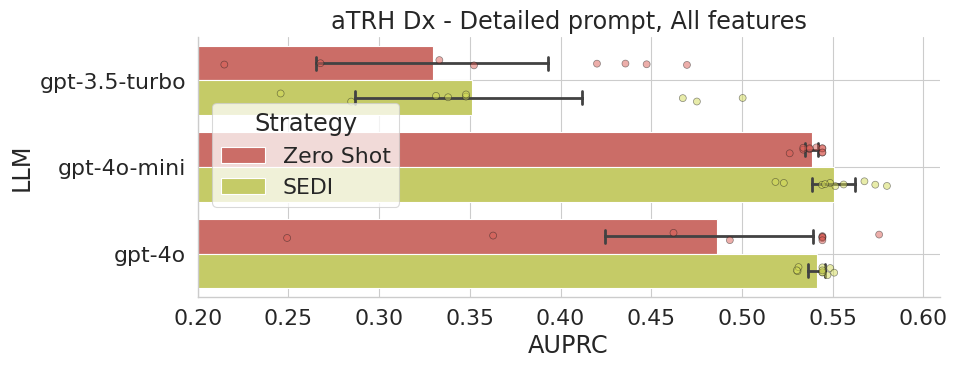

In [7]:
# Compare LLMs
subset = data[(data['target'] == "Resistant HTN Diagnosis") &
                (data['Dx Description'] == "Detailed") &
                (data['Feature Set'] == "Full")]

g = sns.catplot(
    data=subset, y='Model', x=metric_name, order=['gpt-3.5-turbo', 'gpt-4o-mini', 'gpt-4o'],
    hue='Strategy', hue_order=hue_order, palette=palette,
    kind='bar', dodge=True, capsize=.3, errwidth=2, height=4, aspect=2
)
g.map_dataframe(sns.stripplot, x=metric_name, y='Model',
                hue='Strategy', dodge=True, alpha=.5, size=5,
                edgecolor="k", linewidth=0.5, palette=palette)

ax = g.axes.flat[0]

ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set_xlim(left=0.2)
        
sns.move_legend(
    g, 
    "upper left", 
    bbox_to_anchor=(0.22, .73),
    # ncols=2,
    frameon=True,
    framealpha=0.75
)

g.set_ylabels("LLM")
plt.title(f"aTRH Dx - Detailed prompt, All features")
plt.tight_layout()
plt.savefig(f"{poster_dir}/compare_LLMs_aTRH_Dx.pdf", bbox_inches='tight')
plt.savefig(f"{poster_dir}/compare_LLMs_aTRH_Dx.jpeg", bbox_inches='tight')
plt.show()

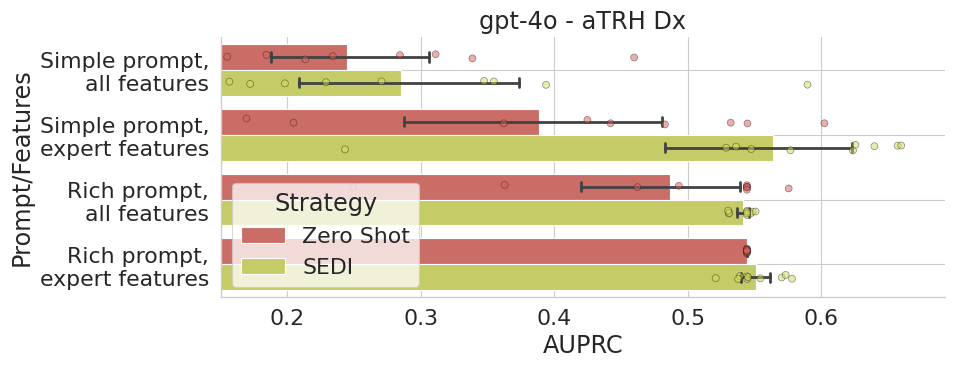

In [8]:
# Compare prompts/features for GPT‑4o on aTRH Dx
subset = data[(data['target'] == "Resistant HTN Diagnosis") &
              (data['Model'] == "gpt-4o")]

order = [
    'Simple prompt,\nall features',
    'Simple prompt,\nexpert features',
    'Rich prompt,\nall features',
    'Rich prompt,\nexpert features',
]

g = sns.catplot(
    data=subset, y='Setting', x=metric_name, order=order,
    hue='Strategy', hue_order=hue_order, palette=palette,
    kind='bar', dodge=True, capsize=.3, errwidth=2, height=4, aspect=2
)
g.map_dataframe(sns.stripplot, x=metric_name, y='Setting',
                hue='Strategy', dodge=True, alpha=.5, size=5,
                edgecolor="k", linewidth=0.5, palette=palette)

ax = g.axes.flat[0]

ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set_xlim(left=0.15)
        
sns.move_legend(
    g, 
    "upper left", 
    bbox_to_anchor=(0.24, .53),
    # ncols=2,
    frameon=True,
    framealpha=0.75
)

g.set_xlabels(metric_name)
g.set_ylabels("Prompt/Features")
plt.title(f"gpt-4o - aTRH Dx")
plt.tight_layout()
plt.savefig(f"{poster_dir}/compare_promptsandfeatures_gpt-4o.pdf", bbox_inches='tight')
plt.savefig(f"{poster_dir}/compare_promptsandfeatures_gpt-4o.jpeg", bbox_inches='tight')
plt.show()